# 2D Gaussian fitting
---

#### Overview
Walkthrough of how curve fitting is done in 2D using `scipy.optimize.curve_fit`

#### References
[1] https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

In [2]:
from psf_extractor import get_Daans_special_cmap

#### Select colormap

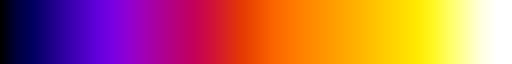

In [3]:
fire = get_Daans_special_cmap()
fire

#### 2D Gaussian function

In [4]:
def gaussian_2D(x, y, x0, y0, sigma_x, sigma_y, A, B):
    """2D Gaussian function with added background"""
    E = (x-x0)**2/(2*sigma_x**2) + (y-y0)**2/(2*sigma_y**2)
    return A * np.exp(-E) + B

#### Synthesize an image with a Gaussian blob

In [5]:
def nonwhite_noise(variance, shape):
    """Generate non-white (correlated) noise"""
    white = np.random.normal(0, 1, shape)
    correlated = gaussian_filter(white, .4)
    return np.sqrt(variance/correlated.var()) * correlated

In [6]:
Nx, Ny = 100, 100
x0 = np.random.uniform(0.2*Nx, 0.8*Nx, 1)[0]
y0 = np.random.uniform(0.2*Ny, 0.8*Ny, 1)[0]
sigma_x = np.random.uniform(Nx/30, Ny/10, 1)[0]
sigma_y = np.random.uniform(Ny/30, Ny/10, 1)[0]
A = np.random.uniform(1, 3, 1)[0]
B = np.random.uniform(0, 1, 1)[0]

# Create meshgrid for x, y data
xx, yy = np.meshgrid(np.arange(Nx), np.arange(Ny))
G = gaussian_2D(xx, yy, x0, y0, sigma_x, sigma_y, A, B)

# Add noise
var = 0.002
mip = G + nonwhite_noise(var, (Ny, Nx))

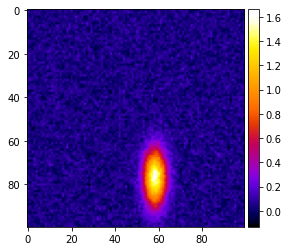

In [7]:
# Plot
fig, ax = plt.subplots()
im = ax.imshow(mip, cmap=fire)
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

#### Estimate parameters

In [8]:
def guess_gaussian_2D_params(image):
    """Make initial estimates for a 2D Gaussian fit"""
    # Mask the central spot
    im = image.copy()
    hm = im < im.max()/2  # threshold at half-maximum
    im[hm] = 0
    xy = np.argwhere(im > 0)
    ys, xs = xy[:, 0], xy[:, 1]

    # Make estimates for x0, y0
    x0, y0 = xs.mean(), ys.mean()

    # Make estimates for sigma_x, sigma_y
    # sigma = FWHM / (2*sqrt(2*ln(2))) ~ FWHM / 2.355
    sigma_x = (xs.max() - xs.min()) / 2.355
    sigma_y = (ys.max() - ys.min()) / 2.355

    # Estimates for amplitude and background
    A = image.max()
    B = image.mean()

    return x0, y0, sigma_x, sigma_y, A, B

In [9]:
# Make estimates
p0 = guess_gaussian_2D_params(mip)

# Preview
out = f"""\
Param   | Real  | Guess
-----------------------
x0      | {x0:.2f} | {p0[0]:.2f}
y0      | {y0:.2f} | {p0[1]:.2f}
sigma_x | {sigma_x:.2f}  | {p0[2]:.2f}
sigma_y | {sigma_y:.2f}  | {p0[3]:.2f}
A       | {A:.2f}  | {p0[4]:.2f}
B       | {B:.2f}  | {p0[5]:.2f}
""";print(out)

Param   | Real  | Guess
-----------------------
x0      | 58.17 | 58.27
y0      | 76.88 | 76.98
sigma_x | 3.58  | 3.40
sigma_y | 8.95  | 8.49
A       | 1.53  | 1.66
B       | 0.04  | 0.07



#### 2D Fit

In [10]:
def _gaussian_2D(M, *args):
    """Wrapper for `gaussian_2D` to pass to `scipy.optimize.curve_fit`

    References
    ----------
    [1] https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/
    """
    # M = array([[ 0,  1,  2, ..., N-2, N-1, N], --> x
    #            [ 0,  0,  0, ..., N, N, N]])    --> y
    x, y = M
    return gaussian_2D(x, y, *args)

In [11]:
# Ravel the meshgrids of X, Y points to a pair of 1-D arrays
X = np.stack((xx.ravel(), yy.ravel()), axis=0)
# Ravel the image data
mip_1D = mip.ravel()

# Non-linear least squares to optimize fitting parameters
popt, pcov = curve_fit(_gaussian_2D, X, mip_1D, p0=p0)

# Preview
out = f"""\
Param   | Real  | Guess | Fit
-------------------------------
x0      | {x0:.2f} | {p0[0]:.2f} | {popt[0]:.2f}
y0      | {y0:.2f} | {p0[1]:.2f} | {popt[1]:.2f}
sigma_x | {sigma_x:.2f}  | {p0[2]:.2f}  | {popt[2]:.2f}
sigma_y | {sigma_y:.2f}  | {p0[3]:.2f}  | {popt[3]:.2f}
A       | {A:.2f}  | {p0[4]:.2f}  | {popt[4]:.2f}
B       | {B:.2f}  | {p0[5]:.2f}  | {popt[5]:.2f}
""";print(out)

Param   | Real  | Guess | Fit
-------------------------------
x0      | 58.17 | 58.27 | 58.22
y0      | 76.88 | 76.98 | 76.87
sigma_x | 3.58  | 3.40  | 3.59
sigma_y | 8.95  | 8.49  | 8.94
A       | 1.53  | 1.66  | 1.53
B       | 0.04  | 0.07  | 0.04



#### Comparison

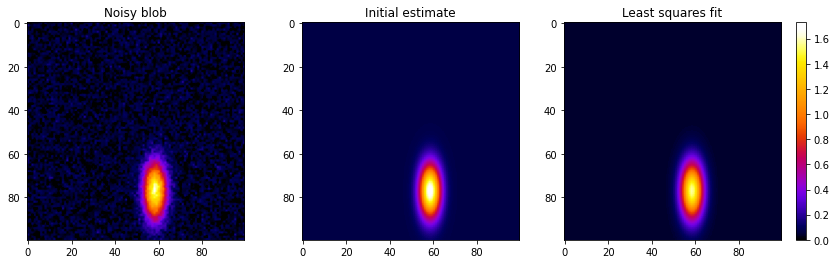

In [12]:
# 2D Gaussian based on initial estimates
guess = gaussian_2D(xx, yy, *p0)
# 2D Gaussian based on non-linear least squares estimate
fit = gaussian_2D(xx, yy, *popt)

# Plot
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
vmax = np.stack([mip, guess, fit]).max()
axes[0].imshow(mip, cmap=fire, vmin=0, vmax=vmax)
axes[1].imshow(guess, cmap=fire, vmin=0, vmax=vmax)
im = axes[2].imshow(fit, cmap=fire, vmin=0, vmax=vmax)
# Colorbar
div = make_axes_locatable(axes[2])
cax = div.append_axes('right', size='5%', pad=0.2)
plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=-0.2)
# Titles
axes[0].set_title('Noisy blob')
axes[1].set_title('Initial estimate')
axes[2].set_title('Least squares fit');

---
#### Batch

In [13]:
# Set up parameters
N = 10
Nx, Ny = 100, 100
x0 = np.random.uniform(0.2*Nx, 0.8*Nx, N)
y0 = np.random.uniform(0.2*Ny, 0.8*Ny, N)
sigma_x = np.random.uniform(Nx/30, Ny/10, N)
sigma_y = np.random.uniform(Ny/30, Ny/10, N)
A = np.random.uniform(1, 5, N)
B = np.random.uniform(0, 1, N)
var = np.random.uniform(0.001, 0.005, N)

# Initialize DataFrame
columns = ['x0', 'y0', 'sigma_x', 'sigma_y', 'A', 'B']
df_mip = pd.DataFrame(columns=columns)

# Generate N (fake) maximum intensity projection images
xx, yy = np.meshgrid(np.arange(Nx), np.arange(Ny))
mips = []
for i in range(N):
    # 2D Gaussian
    params = (x0[i], y0[i], sigma_x[i], sigma_y[i], A[i], B[i])
    G = gaussian_2D(xx, yy, *params)
    # Add noise
    mip = G + nonwhite_noise(var[i], (Ny, Nx))
    mips.append(mip)

    # Populate DataFrame
    df_mip.loc[i, columns] = params

#### Estimate

In [14]:
# Initialize DataFrame
df_guess = pd.DataFrame(columns=columns)
df_fit = pd.DataFrame(columns=columns)
# Collect guesses and fits
guesses = []
fits = []
for i in range(N):
    # Guess
    p0 = guess_gaussian_2D_params(mips[i])

    # Fit
    X = np.stack((xx.ravel(), yy.ravel()), axis=0)
    mip_1D = mips[i].ravel()
    popt, pcov = curve_fit(_gaussian_2D, X, mip_1D, p0=p0)

    # Compile
    guess = gaussian_2D(xx, yy, *p0)
    fit = gaussian_2D(xx, yy, *popt)
    guesses.append(guess)
    fits.append(fit)

    # Tabulate parameters
    df_guess.loc[i, columns] = p0
    df_fit.loc[i, columns] = popt

# Combine fitting data
df = pd.concat([df_mip, df_guess, df_fit], axis=1, keys=['mip', 'guess', 'fit'])\
       .sort_index(axis=1, level=1)
df.head()

,fit,guess,mip,fit,guess,mip,fit,guess,mip,fit,guess,mip,fit,guess,mip,fit,guess,mip
,A,A,A,B,B,B,sigma_x,sigma_x,sigma_x,sigma_y,sigma_y,sigma_y,x0,x0,x0,y0,y0,y0
0,3.182538,4.191474,3.18665,0.977466,1.048631,0.976725,3.994903,4.670913,3.991821,8.952467,11.04034,8.94693,73.282155,73.307054,73.292913,76.391,76.319502,76.418167
1,1.159107,1.924393,1.156267,0.718435,0.749438,0.717211,6.62402,10.615711,6.768037,6.426439,10.615711,6.382169,32.60069,32.448598,32.570722,57.474398,57.523364,57.46476
2,1.336237,1.522691,1.335278,0.18468,0.203057,0.185052,4.662648,4.670913,4.699865,4.694358,5.095541,4.673995,57.929114,58.009009,57.914849,44.167979,44.126126,44.156866
3,2.549238,3.44156,2.548594,0.813263,0.913067,0.813704,9.857604,11.464968,9.896828,6.356922,7.643312,6.349356,74.492723,74.428571,74.51488,75.44389,75.521303,75.455408
4,4.720452,5.61463,4.721618,0.872622,1.01659,0.872351,5.366553,5.944798,5.369865,9.051827,9.766454,9.052572,45.923692,45.878229,45.926633,70.804476,70.708487,70.811409


#### Plot

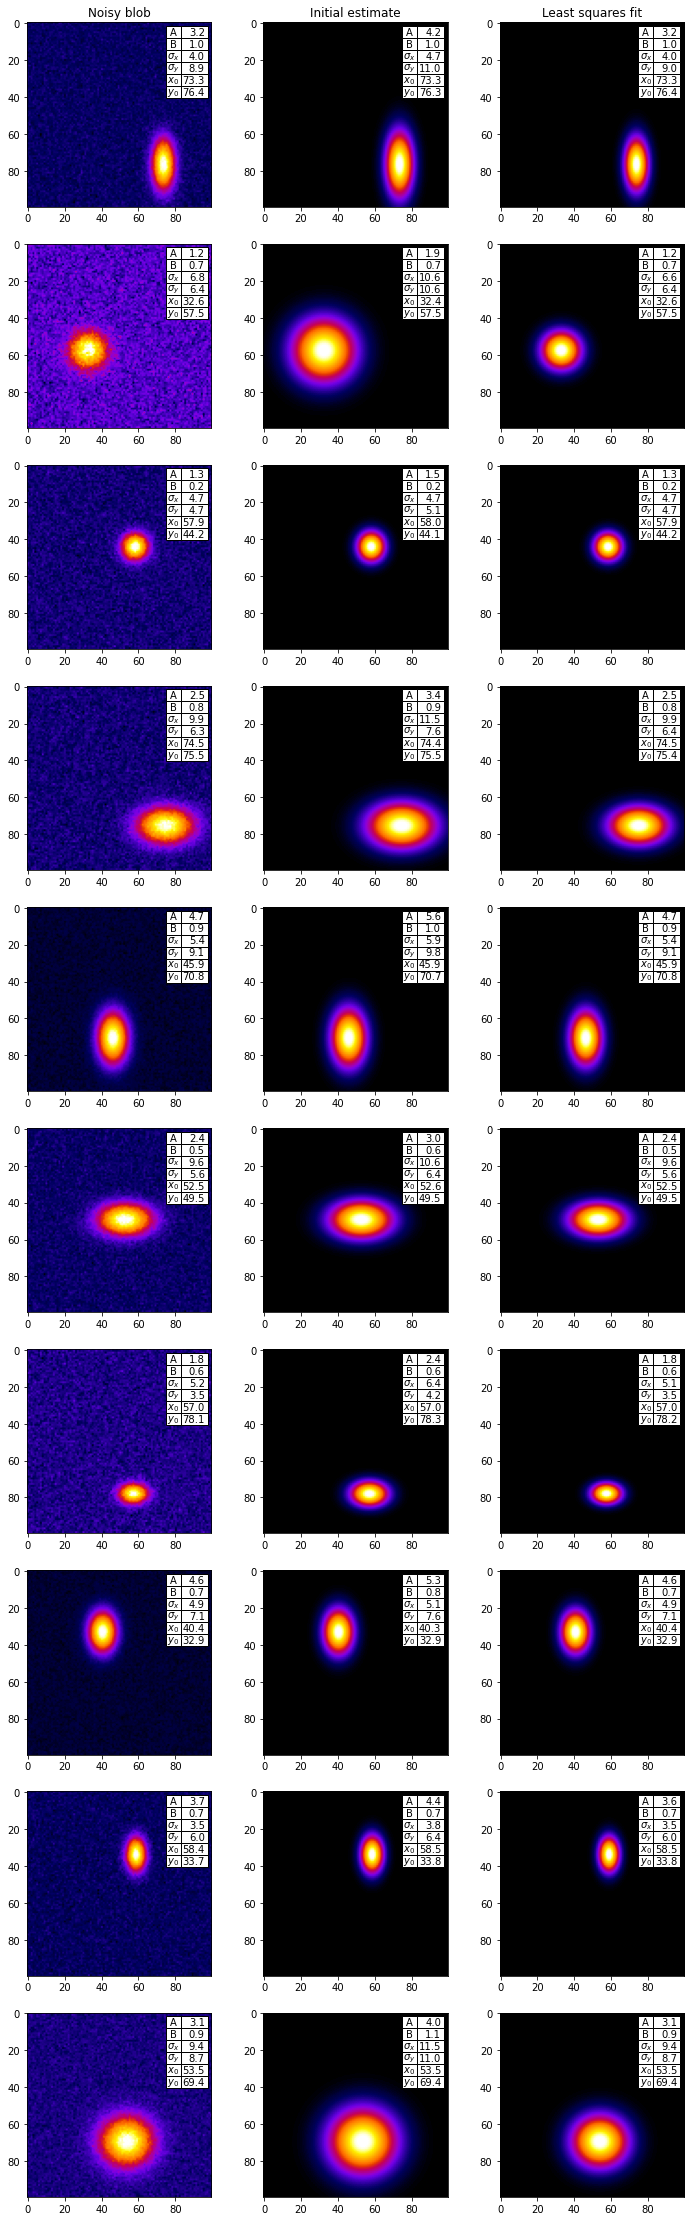

In [15]:
# Create figure
ncols = 3
nrows = N
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
for i in range(N):
    # Plot images
    axes[i,0].imshow(mips[i], cmap=fire)
    axes[i,1].imshow(guesses[i], cmap=fire)
    axes[i,2].imshow(fits[i], cmap=fire)

    # Titles
    if i == 0:
        axes[i, 0].set_title('Noisy blob')
        axes[i, 1].set_title('Initial estimate')
        axes[i, 2].set_title('Least squares fit')

    # Plot tables
    df_m = pd.DataFrame(df.loc[i]['mip']).astype(float).round(1)
    df_g = pd.DataFrame(df.loc[i]['guess']).astype(float).round(1)
    df_f = pd.DataFrame(df.loc[i]['fit']).astype(float).round(1)
    rowLabels = ['A', 'B', '$\sigma_x$', '$\sigma_y$', '$x_0$', '$y_0$']
    tab_m = axes[i, 0].table(cellText=df_m.values, rowLabels=rowLabels,
                             rowLoc='center', loc='upper right', zorder=1)
    tab_g = axes[i, 1].table(cellText=df_g.values, rowLabels=rowLabels,
                             rowLoc='center', loc='upper right', zorder=1)
    tab_f = axes[i, 2].table(cellText=df_f.values, rowLabels=rowLabels,
                             rowLoc='center', loc='upper right', zorder=1)
    tab_m.auto_set_column_width(0)
    tab_g.auto_set_column_width(0)
    tab_f.auto_set_column_width(0)